# Data reduction workflow for files generated on Larmor instrument

Notebook applies pixel dependent direct beam to data reduction workflow developed for SANS2D.
There are few modifications comapred to standard workflow
* Direct beam function has been generate by Mantid
* summation of event from multiple runs (done in function)
* Masking curremtly uses Mantid masks (for debugging purposes) but it is anticpated that scipp masks will be used
* Processed monitors are taken from Mantid directly (however code for processing monitors in scipp is also there).

Notes
* There was a small change in code required to make pixel-dependent direct beam work (https://github.com/scipp/ess/blob/bed91cd51e3979c7fe9df4903d35008db472ef01/src/ess/sans/normalization.py#L160). In addition direct beam from Mantid has to be rebined and midpoints were generated 
* While technically pixel-depent seems to work there are some differances between scipp and Mantid results. Apart from overall scaling of the final results that has to be fudged, there is difference in high Q region of the final result  

In [1]:
import matplotlib.pyplot as plt
import scipp as sc
from ess import loki, sans
import scippneutron as scn
import plopp as pp
%matplotlib widget

## Setting up scicat connection

In [2]:
#TODO: Placeholder for scicat interface

# import scitacean
# scitacean.__version__


# client = FakeClient(file_transfer=FakeFileTransfer(source_folder='/'))

# direct_beam_uploaded = get_direct_beam(client)
# sample_uploaded = get_sample(client, direct_beam_uploaded)

# sample_remote = client.get_dataset(sample_uploaded.pid)
# sample_local = client.download_files(sample_remote, target=".")


### Load masks

## Define reduction workflow parameters

We define here whether to include the effects of gravity,
as well as common time-of-flight, wavelength and $Q$ bins for all the measurements.

We also define a range of wavelengths for the monitors that are considered to not be part of the background.

In [3]:
# Include effects of gravity?
gravity = True

#TODO: Using same wavelengths bins as direct beam is defined for but it may be different range (0.9-13.5)
wavelength_bins = sc.linspace(dim='wavelength', start=2.2, stop=12.0, num=50,
                              unit='angstrom')

q_bins = sc.linspace(dim='Q', start=0.004, stop=0.4, num=110, unit='1/angstrom')


## Loading data files

We load the following files:

- The direct beam function for the main detector (gives detector efficiency as a function of wavelength)
- The sample measurement
- The direct measurement: this is the run with the empty sample holder/cuvette
- the background measurement: this is the run with only the solvent which the sample is placed in

In [4]:
#Loading Mantid
# filename = '60393-mantid-add.nxs'
# path = '/Users/wojciechpotrzebowski/SCIPP_SPACE/direct_beam_iterations_2023/'
# mantid_sample = scn.load(f'{path}/{filename}')
#mantid_sample

In [5]:
def add_runs(runs, data_path): 
    """
    Adding data and monitors from different runs. Iterates over list of runs. 
    Currently returning two data sets, however it may also be possible to create one in order to use workflows
    """
    input_file1 = f'{data_path}/{runs[0]}-2022-02-28_2215.nxs'
    #fixed_file1 = f'{input_file1[:-4]}_fixed.nxs'
    data1 = scn.load_nexus(data_file=input_file1)
    da1 = data1.squeeze().copy()
    summed_data = da1
    summed_monitors_1 = da1.attrs['monitor_1'].value
    summed_monitors_2 = da1.attrs['monitor_2'].value
    #TODO: Should I take tof min and max and use it for setting boundaries

    start_tof = data1.coords['tof'][0].values
    end_tof = data1.coords['tof'][-1].values
    for run in runs[1:]: 
        input_file2 = f'{data_path}/{run}-2022-02-28_2215.nxs'
        #fixed_file2 = f'{input_file2[:-4]}_fixed.nxs'
        data2 = scn.load_nexus(data_file=input_file2)
        if start_tof <  data2.coords['tof'][0].values:
            start_tof =  data1.coords['tof'][0].values
        if end_tof > data2.coords['tof'][-1].values:
            end_tof = data2.coords['tof'][-1].values
        da2 = data2.squeeze().copy()
        summed_data = summed_data.bins.concatenate(da2)
        summed_monitors_1 = summed_monitors_1.bins.concatenate(da2.attrs['monitor_1'].value)
        summed_monitors_2 = summed_monitors_2.bins.concatenate(da2.attrs['monitor_2'].value)

    edges=sc.linspace('tof', start_tof, end_tof, 2, unit='ns')
    summed_binned_data = sc.bin(summed_data, tof=edges)

    #Adding montors from first data set
    summed_binned_data.attrs['monitor_1'] = data1.attrs['monitor_1']
    summed_binned_data.attrs['monitor_2'] = data1.attrs['monitor_2']
    return summed_binned_data

In [6]:
#sample_run_number = 60395
sample_runs = [60250, 60264, 60292, 60308, 60322, 60339, 60353, 60367, 60381, 60395]
sample_transmission_run_number = 60394
#background_run_number = 60393
background_runs = [ 60248, 60262, 60290, 60306, 60320, 60337, 60351, 60365, 60379,  60393]
background_transmission_run_number = 60392
empty_beam_run_number = 60392

path = '/Users/wojciechpotrzebowski/SCIPP_SPACE/loki_detector_test/2022-06-24_calibrated_nexus_files/'
#direct_beam = loki.io.load_rkh_wav(f'{path}/DirectBeam_20feb_full_v3.dat')
direct_beam = scn.load(f'{path}/flat_g4_final_15Jun23_10-17.nxs')

#sample = scn.load_nexus(data_file=f'{path}/{sample_run_number}-2022-02-28_2215.nxs')
sample = add_runs(sample_runs, path)
sample = sample.rename(detector_id = 'spectrum')


#Mantid samples don't have montors, so we will need to pass them independently 
#sample = scn.load(f'{path}/{sample_run_number}-mantid-add.nxs')

sample_trans = scn.load_nexus(data_file=f'{path}/{sample_transmission_run_number}-2022-02-28_2215.nxs')
sample_trans = sample_trans.rename(detector_id = 'spectrum')

#TODO: How about direct?
#ds['direct'] = scn.load(filename=f'{path}/LARMOR000{background_run_number}.nxs')
empty_beam = scn.load_nexus(data_file=f'{path}/{empty_beam_run_number}-2022-02-28_2215.nxs')
empty_beam = empty_beam.rename(detector_id = 'spectrum')

#background = scn.load_nexus(data_file=f'{path}/{background_run_number}-2022-02-28_2215.nxs')
background = add_runs(background_runs, path)
background = background.rename(detector_id = 'spectrum')
#background = scn.load(f'{path}/{background_run_number}-mantid-add.nxs')

background_trans = scn.load_nexus(data_file=f'{path}/{background_transmission_run_number}-2022-02-28_2215.nxs')
background_trans = background_trans.rename(detector_id = 'spectrum')

ds = {'sample': sample, 'sample_trans': sample_trans, 'empty_beam': empty_beam, 
      'background': background, 'background_trans': background_trans}


FrameworkManager-[Notice] Welcome to Mantid 6.7.0
FrameworkManager-[Notice] Please cite: http://dx.doi.org/10.1016/j.nima.2014.07.029 and this release: http://dx.doi.org/10.5286/Software/Mantid6.7
DownloadInstrument-[Notice] All instrument definitions up to date
Load-[Notice] Load started
Load-[Notice] Load successful, Duration 12.80 seconds
DeleteWorkspace-[Notice] DeleteWorkspace started
DeleteWorkspace-[Notice] DeleteWorkspace successful, Duration 0.00 seconds


## Apply corrections to pixel positions

We apply some corrections to the detector pixel and monitor positions,
as the geometry stored in the file is inaccurate.

In [7]:
#sample_position 0, 0, 0 wrt to source?
# Now shift pixels positions to get the correct beam center

for da in ds.values():
    da.coords["sample_position"] = sc.vector(value=[0.0, 0.0, 0.0], unit='m')
    da.coords["source_position"] = sc.vector(value=[0.0, 0.0, -25.61], unit='m')
    #sample_pos_z_offset = 0.1 * sc.units.m
    #bench_pos_y_offset = 0.001 * sc.units.m

    #NOTE: Hack to make solid angle correction invisible
    #L2 = scn.L2(da)
    
    #Values taken from Mantid Nexus file but cannot be true
    da.coords["pixel_width"] = 4.144 * sc.units.m
    da.coords["pixel_height"] = 4.144 * sc.units.m

    x_offset = 0.028 * sc.units.m
    y_offset = 0.01195 * sc.units.m
    z_offset = -0.349 * sc.units.m
    
    # Now shift pixels positions to get the correct beam center
    da.coords['position'].fields.x += x_offset
    da.coords['position'].fields.y += y_offset
    da.coords['position'].fields.z += z_offset
#Direct beam treated separetly 
#direct_beam.coords["sample_position"] = sc.vector(value=[0.0, 0.0, 0.0], unit='m')
#direct_beam.coords["source_position"] = sc.vector(value=[0.0, 0.0, -25.61], unit='m')
# z_offset = -25.26939 * sc.units.m
# direct_beam.coords['position'].fields.z += z_offset

for coord in ['position', 'sample_position', 'source_position']:
    direct_beam.coords[coord] = ds['sample'].meta[coord]
direct_beam.coords["pixel_width"] = 4.144 * sc.units.m
direct_beam.coords["pixel_height"] = 4.144 * sc.units.m


## Masking

The next step is to mask noisy and saturated pixels,
as well as a time-of-flight range that contains spurious artifacts from the beamline components.

**Note:** We use programatic masks here and not those stored in xml files.

### Mask bad pixels

We mask the edges of the detector, which are usually noisy.
We also mask the region close to the center of the beam,
so as to not include saturated pixels in our data reduction.

In [8]:
#Loading Mantid masks
idf_filename = f'{path}/LOKI_test.xml'
mask_file = f'{path}/mask_new_July2022.xml'
mask_all = scn.load(filename=idf_filename, mantid_alg="LoadMask", mantid_args={"InputFile": mask_file})
mask_file = f'{path}/mask_straws.xml' 
mask_straw = scn.load(filename=idf_filename, mantid_alg="LoadMask", mantid_args={"InputFile": mask_file})

mask_edges = (
    (sc.abs(sample.coords['position'].fields.x - x_offset) > sc.scalar(0.45, unit='m')) |
    (sc.abs(sample.coords['position'].fields.y - y_offset) > sc.scalar(0.45, unit='m')))

mask_center = sc.sqrt(
    sample.coords['position'].fields.x**2 +
    sample.coords['position'].fields.y**2) < sc.scalar(0.035, unit='m')

for da in ds.values():
    #da.masks['edges'] = mask_edges
    #da.masks['center'] = mask_center

    da.masks['all'] = mask_all.data
    da.masks['straws'] = mask_straw.data
    #Added mask from direct beam
    #da.masks['direct_beam'] = direct_beam.masks['spectrum']


LoadMask-[Notice] LoadMask started
LoadInstrument-[Warning] The instrument definition filename does not contain _Definition. Your instrument name will be set to: LOKI_test.xml
LoadMask-[Notice] LoadMask successful, Duration 0.38 seconds
DeleteWorkspace-[Notice] DeleteWorkspace started
DeleteWorkspace-[Notice] DeleteWorkspace successful, Duration 0.00 seconds
LoadMask-[Notice] LoadMask started
LoadInstrument-[Warning] The instrument definition filename does not contain _Definition. Your instrument name will be set to: LOKI_test.xml
LoadMask-[Notice] LoadMask successful, Duration 0.41 seconds
DeleteWorkspace-[Notice] DeleteWorkspace started
DeleteWorkspace-[Notice] DeleteWorkspace successful, Duration 0.00 seconds


We can inspect that the coordinate corrections and masking were applied correctly by opening the instrument view.

In [9]:
scn.instrument_view(sample.hist(), pixel_size=0.0075)

Box(children=(Figure(children=(HBar(children=(HTML(value=''),)), HBox(children=(VBar(children=(Toolbar(childre…

### Mask Bragg peaks in wavelength

We will now take out the time regions with Bragg peaks from the beam stop and detector window, although in reality the peaks appear only close to the beam stop, and will make little difference to

This could be implemented as masking specific time bins for a specific region in space, but for now we keep it simple.

In [10]:
#TODO: This needs to be established
# wavelength_mask = sc.DataArray(
#     data=sc.array(dims=['wavelength'], values=[True]),
#     coords={
#         'wavelength': sc.array(
#             dims=['wavelength'], values=[2.21, 2.59], unit='angstrom'
#         )
#     },
# )

#Again to reproduce Mantid workflow no mask has been set
wavelength_mask = None

### Preprocess monitor

In [11]:
monitors = {}
for key, da in ds.items():
    #TODO: Check this histogramming!
    monitors[f'{key}-incident'] = da.attrs["monitor_1"].value.hist(tof=200)
    monitors[f'{key}-transmission'] = da.attrs["monitor_2"].value.hist(tof=200)
    monitors[f'{key}-incident'].coords['source_position'] = sc.vector(value=[0.0, 0.0, -9.8195], unit='m')
    monitors[f'{key}-transmission'].coords['source_position'] = sc.vector(value=[0.0, 0.0, -25.76], unit='m')
    monitors[f'{key}-incident'].coords['position'] = sc.vector(value=[0.0, 0.0, 0.0], unit='m')
    monitors[f'{key}-transmission'].coords['position'] = sc.vector(value=[0.0, 0.0, 0.0], unit='m')

In [12]:
monitor_graph = sans.conversions.sans_monitor()

monitors = {
     key: mon.transform_coords('wavelength', graph=monitor_graph)
     for key, mon in monitors.items()
}

In [13]:
sc.plot(monitors, norm='log', grid=True)

InteractiveFig(children=(HBar(), HBox(children=(VBar(children=(Toolbar(children=(ButtonTool(icon='home', layou…

In [14]:

# Define range outside of which monitor data is considered to be background
non_background_range = sc.array(
    dims=['wavelength'], values=[0.6, 13.7], unit='angstrom'
)

#TODO: It may be required that monitors are histogrammed
# Run preprocessing
monitors = sans.i_of_q.preprocess_monitor_data(
    monitors, non_background_range=non_background_range, wavelength_bins=wavelength_bins
)

# Unpack monitors to make steps below easier
sample_monitors = {
    'incident': monitors['sample_trans-incident'],
    'transmission': monitors['sample_trans-transmission'],
}

empty_beam_monitors = {
    'incident': monitors['empty_beam-incident'],
    'transmission': monitors['empty_beam-transmission'],
}

#Check this! It seems from Mantid code sample_monitors are the same as backgrounds
background_monitors = {
    'incident': monitors['background_trans-incident'],
    'transmission': monitors['background_trans-transmission'],
}

### Trying out with Mantid extracted monitors

In [15]:
mantid_empty_beam_incident = scn.load(f'{path}/empty_beam-incident.nxs')
mantid_empty_beam_transmission = scn.load(f'{path}/empty_beam-transmission.nxs')
mantid_sample_trans_incident = scn.load(f'{path}/sample_trans-incident.nxs')
mantid_sample_trans_transmission = scn.load(f'{path}/sample_trans-transmission.nxs')

Load-[Notice] Load started
Load-[Notice] Load successful, Duration 0.08 seconds
DeleteWorkspace-[Notice] DeleteWorkspace started
DeleteWorkspace-[Notice] DeleteWorkspace successful, Duration 0.00 seconds
Load-[Notice] Load started
Load-[Notice] Load successful, Duration 0.08 seconds
DeleteWorkspace-[Notice] DeleteWorkspace started
DeleteWorkspace-[Notice] DeleteWorkspace successful, Duration 0.00 seconds
Load-[Notice] Load started
Load-[Notice] Load successful, Duration 0.06 seconds
DeleteWorkspace-[Notice] DeleteWorkspace started
DeleteWorkspace-[Notice] DeleteWorkspace successful, Duration 0.00 seconds
Load-[Notice] Load started
Load-[Notice] Load successful, Duration 0.06 seconds
DeleteWorkspace-[Notice] DeleteWorkspace started
DeleteWorkspace-[Notice] DeleteWorkspace successful, Duration 0.00 seconds


In [16]:
mantid_empty_beam_incident = mantid_empty_beam_incident.rebin(wavelength=wavelength_bins)
mantid_empty_beam_transmission = mantid_empty_beam_transmission.rebin(wavelength=wavelength_bins)
mantid_sample_trans_incident = mantid_sample_trans_incident.rebin(wavelength=wavelength_bins)
mantid_sample_trans_transmission = mantid_sample_trans_transmission.rebin(wavelength=wavelength_bins)

In [17]:
mantid_empty_beam_incident.coords['position'] = empty_beam_monitors['incident'].coords['position']
mantid_empty_beam_incident.coords['source_position'] = empty_beam_monitors['incident'].coords['source_position']
mantid_empty_beam_incident.coords['Ltotal'] =  empty_beam_monitors['incident'].coords['Ltotal']

mantid_empty_beam_transmission.coords['position'] = empty_beam_monitors['transmission'].coords['position']
mantid_empty_beam_transmission.coords['source_position'] = empty_beam_monitors['transmission'].coords['source_position']
mantid_empty_beam_transmission.coords['Ltotal'] = empty_beam_monitors['transmission'].coords['Ltotal']

mantid_sample_trans_incident.coords['position'] = sample_monitors['incident'].coords['position']
mantid_sample_trans_incident.coords['source_position'] = sample_monitors['incident'].coords['source_position']
mantid_sample_trans_incident.coords['Ltotal'] = sample_monitors['incident'].coords['Ltotal']

mantid_sample_trans_transmission.coords['position'] = sample_monitors['transmission'].coords['position']
mantid_sample_trans_transmission.coords['source_position'] = sample_monitors['transmission'].coords['source_position']
mantid_sample_trans_transmission.coords['Ltotal'] = sample_monitors['transmission'].coords['Ltotal']

for mantid_monitor in [mantid_empty_beam_incident, mantid_empty_beam_transmission, mantid_sample_trans_incident, mantid_sample_trans_transmission]:
    mantid_monitor.coords['sample_position'] =  sc.vector(value=[0.0, 0.0, 0.0], unit='m')
    mantid_monitor.variances = None

In [18]:
sample_monitors = {'incident': mantid_sample_trans_incident, 'transmission': mantid_sample_trans_transmission}
empty_beam_monitors = {'incident': mantid_empty_beam_incident, 'transmission': mantid_empty_beam_transmission}
background_monitors = {'incident': mantid_empty_beam_incident, 'transmission': mantid_empty_beam_transmission}

### Direct beam midpoints
This operation is needed for performing interpolation. Later, this can probably be dome i_of_q module, however we still need to see what exactly the format of direct beam function would be. 

In [19]:
direct_beam = direct_beam.rebin(wavelength=wavelength_bins)
direct_beam.coords['wavelength'] = sc.midpoints(direct_beam.coords['wavelength'])

In [20]:
# direct_beam_copy['spectrum', 323737].plot()

In [21]:
direct_beam_selected = direct_beam['spectrum', 173162]

In [22]:
direct_beam_selected.plot()

InteractiveFig(children=(HBar(), HBox(children=(VBar(children=(Toolbar(children=(ButtonTool(icon='home', layou…

### Debugging check

In [23]:
#graph = sans.conversions.sans_elastic(gravity=gravity)
# data = ds['sample'].transform_coords("wavelength", graph=graph)
# signal_over_monitor_threshold = 0.1
# if wavelength_mask is not None:
#     # If we have binned data and the wavelength coord is multi-dimensional, we need
#     # to make a single wavelength bin before we can mask the range.
#     if data.bins is not None:
#         dim = wavelength_mask.dim
#         if (dim in data.bins.coords) and (dim in data.coords):
#             data = data.bin({dim: 1})
#     data = sans.common.mask_range(data, wavelength_mask)
#     data_monitors = {
#             key: sans.common.mask_range(mon, wavelength_mask) for key, mon in sample_monitors.items()
#         }
#     direct_monitors = {
#             key: sans.common.mask_range(mon, wavelength_mask)
#             for key, mon in empty_beam_monitors.items()
#         }

# # Compute normalizing term
#direct_beam = sans.i_of_q.resample_direct_beam(
#         direct_beam=direct_beam, wavelength_bins=wavelength_bins)

# signal_over_monitor_threshold = 0.5
# denominator = sans.normalization.iofq_denominator(
#         data=ds['sample'],
#         data_transmission_monitor=sample_monitors['transmission'],
#         direct_incident_monitor=empty_beam_monitors['incident'],
#         direct_transmission_monitor=empty_beam_monitors['transmission'],
#         direct_beam=direct_beam,
# )

# for coord in ['position', 'sample_position', 'source_position']:
#     denominator.coords[coord] = data.meta[coord]

#     # In the case where no wavelength bands are requested, we create a single wavelength
#     # band to make sure we select the correct wavelength range that corresponds to
#     # wavelength_bins


# wavelength_bands = sc.concat([wavelength_bins.min(), wavelength_bins.max()], dim='wavelength')

In [24]:
direct_beam

<scipp.DataArray>
Dimensions: Sizes[spectrum:458752, wavelength:49, ]
Coordinates:
* pixel_height              float64              [m]  ()  4.144
* pixel_width               float64              [m]  ()  4.144
* position                  vector3              [m]  (spectrum)  [(-0.471023, 0.44637, 3.74233), (-0.469074, 0.44637, 3.74233), ..., (0.523061, -0.41291, 3.83645), (0.52501, -0.41291, 3.83645)]
* sample_position           vector3              [m]  ()  (0, 0, 0)
* source_position           vector3              [m]  ()  (0, 0, -25.61)
* spectrum                    int32        <no unit>  (spectrum)  [1, 2, ..., 458751, 458752]
* wavelength                float64             [Å]  (wavelength)  [2.3, 2.5, ..., 11.7, 11.9]
Data:
                            float64  [dimensionless]  (spectrum, wavelength)  [0, 0, ..., 0, 0]  [0, 0, ..., 0, 0]
Masks:
  spectrum                     bool        <no unit>  (spectrum)  [True, True, ..., True, True]
Attributes:
  TimeUnit                   string  [dimensionless]  ()  "Micro Seconds"
  deltaE-mode                string  [dimensionless]  ()  "Elastic"
  end_time                   string  [dimensionless]  ()  "2022-04-14T13:25:19.880580000"
  instrument_name            string        <no unit>  ()  "LOKI_test.xml"
  run_number                 string  [dimensionless]  ()  "1"
  run_start                  string  [dimensionless]  ()  "2022-04-14T13:25:19.880580000"
  run_title                  string  [dimensionless]  ()  ""
  sample                   PyObject        <no unit>  ()  <mantid.api._api.Sample object at 0x7fa4f49ba0b0>
  start_time                 string  [dimensionless]  ()  "2022-04-14T13:25:19.880580000"

In [25]:
#pp.superplot(denominator)

In [26]:
#pp.superplot(denominator.transpose())

In [27]:
# data_q = sans.i_of_q.convert_to_q_and_merge_spectra(
#         data=data,
#         graph=graph,
#         wavelength_bands=wavelength_bands,
#         q_bins=q_bins,
#         gravity=gravity,
#     )

In [28]:
# denominator_q = sans.i_of_q.convert_to_q_and_merge_spectra(
#         data=denominator,
#         graph=graph,
#         wavelength_bands=wavelength_bands,
#         q_bins=q_bins,
#         gravity=gravity,
#     )

In [29]:
#NOTE: direct monitors is the same as sample (and backgroud)
sample_q = sans.to_I_of_Q(data=ds['sample'],
    data_monitors=sample_monitors,
    direct_monitors=empty_beam_monitors,
    direct_beam=direct_beam,
    wavelength_bins=wavelength_bins,
    q_bins=q_bins,
    gravity=gravity,
    wavelength_mask=wavelength_mask)

An interpolation was performed on the direct_beam function. The variances in the direct_beam function have been dropped.


In [30]:
background_q = sans.to_I_of_Q(data=ds['background'],
    data_monitors=background_monitors,
    direct_monitors=empty_beam_monitors,
    direct_beam=direct_beam,
    wavelength_bins=wavelength_bins,
    q_bins=q_bins,
    gravity=gravity,
    wavelength_mask=wavelength_mask)

An interpolation was performed on the direct_beam function. The variances in the direct_beam function have been dropped.


We are now in a position to subtract the background from the sample measurement:

In [31]:
result = sample_q.bins.sum() - background_q.bins.sum()

In [32]:
background_q.bins.sum().plot()

InteractiveFig(children=(HBar(), HBox(children=(VBar(children=(Toolbar(children=(ButtonTool(icon='home', layou…

In [33]:
#NOTE: direct monitors is the same as sample (and backgroud)
sample_q_selected = sans.to_I_of_Q(data=ds['sample'],
    data_monitors=sample_monitors,
    direct_monitors=empty_beam_monitors,
    direct_beam=direct_beam_selected,
    wavelength_bins=wavelength_bins,
    q_bins=q_bins,
    gravity=gravity,
    wavelength_mask=wavelength_mask)

An interpolation was performed on the direct_beam function. The variances in the direct_beam function have been dropped.


In [34]:
background_q_selected = sans.to_I_of_Q(data=ds['background'],
    data_monitors=background_monitors,
    direct_monitors=empty_beam_monitors,
    direct_beam=direct_beam_selected,
    wavelength_bins=wavelength_bins,
    q_bins=q_bins,
    gravity=gravity,
    wavelength_mask=wavelength_mask)

An interpolation was performed on the direct_beam function. The variances in the direct_beam function have been dropped.


In [35]:
result_selected = sample_q_selected.bins.sum() - background_q_selected.bins.sum()

In [36]:
result_selected.plot()

InteractiveFig(children=(HBar(), HBox(children=(VBar(children=(Toolbar(children=(ButtonTool(icon='home', layou…

In [37]:
sc.plot({'selected': result_selected, 'full': result})

InteractiveFig(children=(HBar(), HBox(children=(VBar(children=(Toolbar(children=(ButtonTool(icon='home', layou…

In [38]:
mantid_result = scn.load(f'{path}/ISIS_polymer_mantid_no_solid_angle.nxs')

Load-[Notice] Load started
ISISRunLogs-[Warning] Cannot find period log. Logs will be not be filtered by current period
ISISRunLogs-[Warning] Cannot find periods log. Logs will be not be filtered by current period
Load-[Notice] Load successful, Duration 0.91 seconds
DeleteWorkspace-[Notice] DeleteWorkspace started
DeleteWorkspace-[Notice] DeleteWorkspace successful, Duration 0.00 seconds


In [39]:
mantid_result.data.unit = 'counts'

In [40]:
sc.plot({'scipp': result, 'mantid': 0.3e-10 * mantid_result})

InteractiveFig(children=(HBar(), HBox(children=(VBar(children=(Toolbar(children=(ButtonTool(icon='home', layou…

<div class="alert alert-info">

**Note**

Instead of `.bins.sum()`,
one could use `sc.histogram()` above to define different `Q` bins compared to the ones defined at the top of the notebook.
This can be done in event mode, see [here](https://scipp.github.io/user-guide/binned-data/computation.html#Subtraction).

There may be performance advantages to first use a coarse `Q` binning when the computing `I(Q)` numerator,
and use finer binning for the final results.

</div>

## Wavelength bands

It is often useful to process the data in a small number (~10) of separate wavelength bands.

This can be achieved by requesting 10 bands from the `to_I_of_Q` workflow via the `wavelength_bands` argument.

In [41]:
wavelength_bands = sc.linspace(dim='wavelength', start=2.2, stop=12.0, num=10,
                               unit='angstrom')

sample_slices = sans.to_I_of_Q(data=ds['sample'],
    data_monitors=sample_monitors,
    direct_monitors=sample_monitors,
    direct_beam=direct_beam,
    wavelength_bins=wavelength_bins,
    q_bins=q_bins,
    gravity=gravity,
    wavelength_bands=wavelength_bands,
    wavelength_mask=wavelength_mask)

background_slices = sans.to_I_of_Q(data=ds['background'],
    data_monitors=background_monitors,
    direct_monitors=background_monitors,
    direct_beam=direct_beam,
    wavelength_bins=wavelength_bins,
    q_bins=q_bins,
    gravity=gravity,
    wavelength_bands=wavelength_bands,
    wavelength_mask=wavelength_mask)

result_slices = sample_slices.bins.sum() - background_slices.bins.sum()
result_slices

An interpolation was performed on the direct_beam function. The variances in the direct_beam function have been dropped.
An interpolation was performed on the direct_beam function. The variances in the direct_beam function have been dropped.


<scipp.DataArray>
Dimensions: Sizes[Q:109, wavelength:9, ]
Coordinates:
  L1                        float64              [m]  ()  25.61
* Q                         float64           [1/Å]  (Q [bin-edge])  [0.004, 0.00763303, ..., 0.396367, 0.4]
  gravity                   vector3          [m/s^2]  ()  (0, -9.80665, 0)
  incident_beam             vector3              [m]  ()  (0, 0, 25.61)
* pixel_height              float64              [m]  ()  4.144
* pixel_shape             DatasetView        <no unit>  ()  <scipp.Dataset>
Dimensions: Sizes[cylinder:1, ]
Data:
  face1_center              vector3              [m]  (cylinder)  [(0, 0, 0)]
  face1_edge                vector3              [m]  (cylinder)  [(0, -0.00257703, 0.00305923)]
  face2_center              vector3              [m]  (cylinder)  [(0.00194919, 0, 0)]


* pixel_width               float64              [m]  ()  4.144
  sample_position           vector3              [m]  ()  (0, 0, 0)
  source_position           vector3              [m]  ()  (0, 0, -25.61)
* wavelength                float64             [Å]  (wavelength [bin-edge])  [2.2, 3.28889, ..., 10.9111, 12]
Data:
                            float32         [counts]  (Q, wavelength)  [0, 0, ..., 0, 0]
Attributes:
  end_time                   string        <no unit>  ()  "2032-02-29T09:15:00.000Z"
  experiment_title           string        <no unit>  ()  "My experiment"
  position_transformations Variable        <no unit>  ()  Variable(dims=(), dtype=translation3, unit=m)
  source                   PyObject        <no unit>  ()  DataGroup(sizes={}, keys=['name', 'probe', 'type', 'depends_on'])
  start_time                 string        <no unit>  ()  "2022-02-28T21:15:00.000Z"

InteractiveFig(children=(HBar(), HBox(children=(VBar(children=(Toolbar(children=(ButtonTool(icon='home', layou…

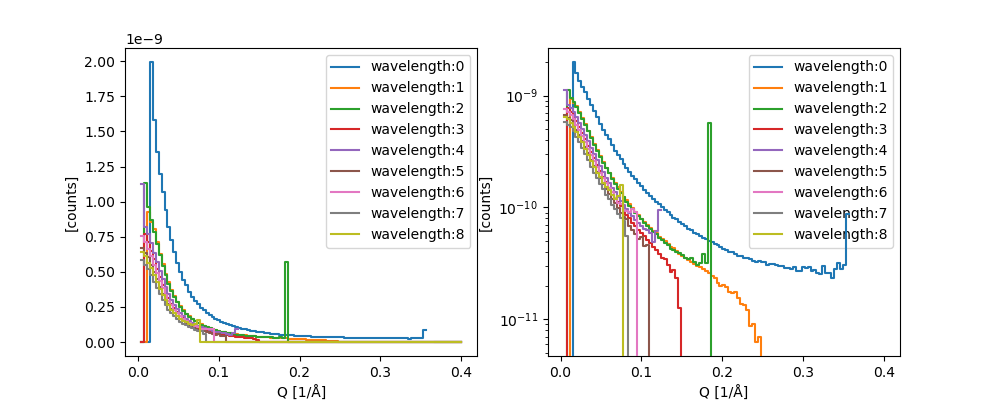

In [42]:
collapsed = sc.collapse(result_slices, keep='Q')

fig2, ax2 = plt.subplots(1, 2, figsize=(10, 4))
sc.plot(collapsed, ax=ax2[0])
sc.plot(collapsed, norm='log', ax=ax2[1])


### Comparison with Mantid for a single slice
- First denominator
- Then slice

In [43]:
#Calculating denominator for a slice
graph = sans.conversions.sans_elastic(gravity=gravity)
direct_beam = sans.i_of_q.resample_direct_beam(
         direct_beam=direct_beam, wavelength_bins=wavelength_bins)

denominator_wav = sans.normalization.iofq_denominator(
    data=ds['sample'],
    data_transmission_monitor=sample_monitors['transmission'],
    direct_incident_monitor=empty_beam_monitors['incident'],
    direct_transmission_monitor=empty_beam_monitors['transmission'],
    direct_beam=direct_beam
)

# Insert a copy of coords needed for conversion to Q.
# TODO: can this be avoided by copying the Q coords from the converted numerator?
for coord in ['position', 'sample_position', 'source_position']:
    denominator_wav.coords[coord] = ds['sample'].meta[coord]


denominator_q_bands = sans.i_of_q.convert_to_q_and_merge_spectra(
        data=denominator_wav,
        graph=graph,
        wavelength_bands=wavelength_bands,
        q_bins=q_bins,
        gravity=gravity,
    )

An interpolation was performed on the direct_beam function. The variances in the direct_beam function have been dropped.


In [44]:
mantid_denominator_band_1 = scn.load(f'{path}/denominator_2-3.18_sa.nxs')
mantid_denominator_band_1.data.unit = 'dimensionless'

Load-[Notice] Load started
ISISRunLogs-[Warning] Cannot find period log. Logs will be not be filtered by current period
ISISRunLogs-[Warning] Cannot find periods log. Logs will be not be filtered by current period
Load-[Notice] Load successful, Duration 0.75 seconds
DeleteWorkspace-[Notice] DeleteWorkspace started
DeleteWorkspace-[Notice] DeleteWorkspace successful, Duration 0.00 seconds


In [45]:
sc.plot({'scipp denominator': 3.4e-8*denominator_q_bands['wavelength', 0], 
         'mantid denominator' :  8.7e8*mantid_denominator_band_1})

InteractiveFig(children=(HBar(), HBox(children=(VBar(children=(Toolbar(children=(ButtonTool(icon='home', layou…

In [46]:
mantid_slice_0 = scn.load(f'{path}/ISIS_polymer_slice_0.nxs')

Load-[Notice] Load started
ISISRunLogs-[Warning] Cannot find period log. Logs will be not be filtered by current period
ISISRunLogs-[Warning] Cannot find periods log. Logs will be not be filtered by current period
Load-[Notice] Load successful, Duration 0.70 seconds
DeleteWorkspace-[Notice] DeleteWorkspace started
DeleteWorkspace-[Notice] DeleteWorkspace successful, Duration 0.00 seconds


In [47]:
result_slices['wavelength', 0].plot()
sc.plot({'scipp slice 0': result_slices['wavelength', 0], 
         'mantid slice 0':  5e-17*mantid_slice_0})

InteractiveFig(children=(HBar(), HBox(children=(VBar(children=(Toolbar(children=(ButtonTool(icon='home', layou…

## Adding reduced data to scicat

In [48]:


# reduced = sample_local.derive()

# reduced.add_local_files('./offspec.ort', base_path='.')
# reduced.contact_email = 'andrew.mccluskey@ess.eu'
# reduced.input_datasets.append(direct_beam_local.pid)
# reduced.name = 'Reduced reflectometry data from QCS sample'
# reduced.used_software = ['scipp-23.01.1']
# reduced.investigator = 'Andrew R. McCluskey'
# reduced.owner_group = sample_local.owner_group

# reduced_up = client.upload_new_dataset_now(reduced)



In [49]:
mantid_sample = scn.load(f'{path}/mantid_sample.nxs')

Load-[Notice] Load started
ISISRunLogs-[Warning] Cannot find period log. Logs will be not be filtered by current period
ISISRunLogs-[Warning] Cannot find periods log. Logs will be not be filtered by current period
Load-[Notice] Load successful, Duration 1.19 seconds
DeleteWorkspace-[Notice] DeleteWorkspace started
DeleteWorkspace-[Notice] DeleteWorkspace successful, Duration 0.00 seconds


In [50]:
mantid_sample 

<scipp.DataArray>
Dimensions: Sizes[spectrum:458752, wavelength:1, ]
Coordinates:
* position                  vector3              [m]  (spectrum)  [(0.451023, 0.446362, 29.4041), (0.44907, 0.446362, 29.4041), ..., (-0.54507, -0.412919, 29.4982), (-0.547023, -0.412919, 29.4982)]
* sample_position           vector3              [m]  ()  (0, 0, 25.61)
* source_position           vector3              [m]  ()  (0, 0, 0)
* spectrum                    int32        <no unit>  (spectrum)  [1, 2, ..., 458751, 458752]
* wavelength                float64             [Å]  (wavelength [bin-edge])  [2.2, 12]
Data:
                          DataArrayView        <no unit>  (spectrum, wavelength)  binned data: dim='event', content=DataArray(
          dims=(event: 14613075),
          data=float32[counts],
          coords={'wavelength':float64[Å], 'pulse_time':datetime64[ns]})
Masks:
  spectrum                     bool        <no unit>  (spectrum)  [True, True, ..., True, True]
Attributes:
  Filename                   string  [dimensionless]  ()  "/Users/judithhouston/Documents/ESS/LoKi/Design_documents/Detector/Larmor2022/..."
  deltaE-mode                string  [dimensionless]  ()  "Elastic"
  end_time                   string  [dimensionless]  ()  "2032-02-29T09:15:00"
  experiment_identifier      string  [dimensionless]  ()  "p1234"
  instrument_name            string        <no unit>  ()  "LOKI_test.xml"
  run_start                  string  [dimensionless]  ()  "2022-02-28T21:15:00"
  run_title                  string  [dimensionless]  ()  "My experiment"
  running                 DataArray        <no unit>  ()  DataArray(dims=(time: 1), dtype=bool, unit=dimensionless)
  sample                   PyObject        <no unit>  ()  <mantid.api._api.Sample object at 0x7fa5025d87b0>
  start_time                 string  [dimensionless]  ()  "2022-02-28T21:15:00"

In [51]:
ds['sample']

<scipp.DataArray>
Dimensions: Sizes[spectrum:458752, tof:1, ]
Coordinates:
* pixel_height              float64              [m]  ()  4.144
* pixel_shape             DatasetView        <no unit>  ()  <scipp.Dataset>
Dimensions: Sizes[cylinder:1, ]
Data:
  face1_center              vector3              [m]  (cylinder)  [(0, 0, 0)]
  face1_edge                vector3              [m]  (cylinder)  [(0, -0.00257703, 0.00305923)]
  face2_center              vector3              [m]  (cylinder)  [(0.00194919, 0, 0)]


* pixel_width               float64              [m]  ()  4.144
* position                  vector3              [m]  (spectrum)  [(-0.471023, 0.44637, 3.74233), (-0.469074, 0.44637, 3.74233), ..., (0.523061, -0.41291, 3.83645), (0.52501, -0.41291, 3.83645)]
* sample_position           vector3              [m]  ()  (0, 0, 0)
* source_position           vector3              [m]  ()  (0, 0, -25.61)
* spectrum                    int32        <no unit>  (spectrum)  [1, 2, ..., 458751, 458752]
* tof                       float64             [ns]  (tof [bin-edge])  [284, 9.99994e+07]
Data:
                          DataArrayView        <no unit>  (spectrum, tof)  binned data: dim='event', content=DataArray(
          dims=(event: 17419279),
          data=float32[counts],
          coords={'tof':int32[ns], 'pulse_time':datetime64[ns]})
Masks:
  all                          bool        <no unit>  (spectrum)  [True, True, ..., True, True]
  straws                       bool        <no unit>  (spectrum)  [False, False, ..., True, True]
Attributes:
  base_position             vector3              [m]  (spectrum)  [(0, -0.00114, -0.00767), (0.00194919, -0.00114, -0.00767), ..., (0.994085, -0.86042, 0.086447), (0.996034, -0.86042, 0.086447)]
  end_time                   string        <no unit>  ()  "2032-02-29T09:15:00.000Z"
  experiment_title           string        <no unit>  ()  "My experiment"
  monitor_1               DataArray        <no unit>  ()  DataArray(dims=(tof: 1), dtype=DataArrayView)
  monitor_2               DataArray        <no unit>  ()  DataArray(dims=(tof: 1), dtype=DataArrayView)
  position_transformations Variable        <no unit>  ()  Variable(dims=(), dtype=translation3, unit=m)
  source                   PyObject        <no unit>  ()  DataGroup(sizes={}, keys=['name', 'probe', 'type', 'depends_on'])
  start_time                 string        <no unit>  ()  "2022-02-28T21:15:00.000Z"